In [1]:
import KID_model_functions as kids
import fitting_KID_model_functions as fitkids
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from scipy.optimize import curve_fit
from astropy import units as u, constants as c
from glob import glob
from scipy.interpolate import CubicSpline 

In [2]:
save=True
plotlabel='LTDdata_unbounded_residuals'
#trans = 0.03

In [3]:
# Load in data: want lists of Sxx vs Tstage (dark) and x and Sxx vs T_BB (optical)
# doing this the brute force way because .csv isn't cooperating
Tstagedarkpts = np.array([0.213,0.225,0.250,0.275,0.3,0.325])
sxxdarkpts = np.array([2.1348958e-17,2.3151119e-17,3.3760155e-17,3.9041305e-17,5.0851221e-17,5.4271643e-17])
sxxdarkerr = np.array([1.6182373e-18,1.7292262e-18,1.7178546e-18,3.7833633e-18,6.6792896e-18,6.7496988e-18])

Pincfulloptpts = np.array([0.13447390,0.18111091,0.28131964,0.41245929,0.57701855,0.77665690,1.0122914,1.5921849,2.3135104])
xfulloptpts = np.array([0,-7.9498079e-06,-2.5715198e-05,-4.5827445e-05,-6.9392014e-05,-9.8349709e-05,-0.00012798868,-0.00019504369,-0.00025532634])
sxxfulloptpts = np.array([5.7032281e-17,7.4020492e-17,8.6542582e-17,1.0538483e-16,1.1351225e-16,1.2821137e-16,1.3910934e-16,1.4928895e-16,1.6568856e-16
])
xfullopterr = 0.05*xfulloptpts
sxxfullopterr = 0.05*sxxfulloptpts

# reverse engineer the BB temps from LTD data
tbb = np.linspace(1,20,num=1000)*u.K
pinc = kids.TBB_to_Pinc(tbb,trans=1)
tempfunc = CubicSpline(pinc,tbb)
TBBfulloptpts = tempfunc(Pincfulloptpts)

In [4]:
# Parameters to hold constant in the fit
alpha = 0.73*u.dimensionless_unscaled
f = 245*u.MHz
Tstage = 0.215*u.K
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

# Data to pass into fitter
xdata = np.concatenate((TBBfulloptpts,TBBfulloptpts,Tstagedarkpts))
ydata = np.concatenate((xfulloptpts,sxxfulloptpts,sxxdarkpts))
yerr = np.concatenate((xfullopterr,sxxfullopterr,sxxdarkerr))
yerr[0] = yerr[1]
#p0 = [200,50,.8,1e-8,.5e-17,.5e-17]
#bounds = ([10,10,0,-1,1e-19,1e-19],[1e5,1e3,1,1,np.min(sxxfulloptpts),np.min(sxxdarkpts)])
p0 = [1380,22,.2,1e-7,1.32e-17,1.75e-17]
bounds = ([10,10,0,-1,1e-19,1e-19],[1e5,1e3,1,1,np.min(sxxfulloptpts),np.min(sxxdarkpts)])
#bounds = ([10,10,0,-1,1e-19,1e-19],[1e5,1e3,1,1,np.min(sxxfulloptpts),np.min(sxxdarkpts)])

i1 = len(xfulloptpts)
i2 = i1+len(sxxfulloptpts)

print(len(xdata),len(ydata))

24 24


In [5]:
print(ydata)
print(yerr)
np.min(sxxfulloptpts)

[ 0.0000000e+00 -7.9498079e-06 -2.5715198e-05 -4.5827445e-05
 -6.9392014e-05 -9.8349709e-05 -1.2798868e-04 -1.9504369e-04
 -2.5532634e-04  5.7032281e-17  7.4020492e-17  8.6542582e-17
  1.0538483e-16  1.1351225e-16  1.2821137e-16  1.3910934e-16
  1.4928895e-16  1.6568856e-16  2.1348958e-17  2.3151119e-17
  3.3760155e-17  3.9041305e-17  5.0851221e-17  5.4271643e-17]
[-3.97490395e-07 -3.97490395e-07 -1.28575990e-06 -2.29137225e-06
 -3.46960070e-06 -4.91748545e-06 -6.39943400e-06 -9.75218450e-06
 -1.27663170e-05  2.85161405e-18  3.70102460e-18  4.32712910e-18
  5.26924150e-18  5.67561250e-18  6.41056850e-18  6.95546700e-18
  7.46444750e-18  8.28442800e-18  1.61823730e-18  1.72922620e-18
  1.71785460e-18  3.78336330e-18  6.67928960e-18  6.74969880e-18]


5.7032281e-17

In [6]:
# function to fit x vs TBB
xfulloptfunc = lambda T_BBi,n_starp,tau_maxp,eta_optp,dfp: kids.xMB(alpha,f,Tstage,Tc,T_BBi,V,n_starp,tau_maxp,eta_pb,eta_optp,1,N0)+(dfp*f.value)

# function to fit Sxx vs TBB (no mask; T = 1)
sxxfulloptfunc = lambda T_BBi,n_starp,tau_maxp,eta_optp,Sxx0optp: kids.Sxx(alpha,f,Tstage,Tc,T_BBi,V,n_starp,tau_maxp,eta_pb,nu_opt,eta_optp,trans=1,N0=N0).value+Sxx0optp

# function to fit Sxx vs Tstage
sxxdarkfunc = lambda T_stagei,n_starp,tau_maxp,Sxx0darkp: kids.Sxx(alpha,f,T_stagei,Tc,TBB_0,V,n_starp,tau_maxp,eta_pb,nu_opt,eta_opt=0,trans=0,N0=N0).value+Sxx0darkp

combfunc = lambda datai,n_starp,tau_maxp,eta_optp,dfp,Sxx0optp,Sxx0darkp: np.concatenate((xfulloptfunc(datai[0:i1],n_starp,tau_maxp,eta_optp,dfp),
                                                                                        sxxfulloptfunc(datai[i1:i2],n_starp,tau_maxp,eta_optp,Sxx0optp),
                                                                                        sxxdarkfunc(datai[i2::],n_starp,tau_maxp,Sxx0darkp)))

In [7]:
comb_popt,comb_pcov = curve_fit(combfunc,xdata,ydata,p0=p0,sigma=yerr,absolute_sigma=True)
#comb_popt,comb_pcov = curve_fit(combfunc,xdata,ydata,p0=p0,bounds=bounds)
print(comb_popt)

comb_perr = np.sqrt(np.diag(comb_pcov))
print(comb_perr)

[1.64816215e+03 1.87700142e+01 2.17286305e-01 1.52291111e-07
 2.99647359e-17 1.43470450e-17]
[2.62063121e+02 2.45971553e+00 2.15385750e-02 4.44324342e-09
 5.49894011e-18 1.49852253e-18]


In [8]:
n_star_fit,tau_max_fit,eta_opt_fit,df_fit,Sxx0opt_fit,Sxx0dark_fit = comb_popt

Tstagefit = np.linspace(Tstagedarkpts.min(),Tstagedarkpts.max(),num=50)
sxxdarkfit = sxxdarkfunc(Tstagefit,n_star_fit,tau_max_fit,Sxx0dark_fit)
sxxdarkresid = sxxdarkpts-sxxdarkfunc(Tstagedarkpts,n_star_fit,tau_max_fit,Sxx0dark_fit)

TBBfulloptfit = np.linspace(0,2*TBBfulloptpts.max(),num=50)
Pincfulloptpts = kids.TBB_to_Pinc(TBBfulloptpts,trans=1)

xfulloptfit  = xfulloptfunc(TBBfulloptfit,n_star_fit,tau_max_fit,eta_opt_fit,df_fit)
xfulloptresid = xfulloptpts-xfulloptfunc(TBBfulloptpts,n_star_fit,tau_max_fit,eta_opt_fit,df_fit)

sxxfulloptfit = sxxfulloptfunc(TBBfulloptfit,n_star_fit,tau_max_fit,eta_opt_fit,Sxx0opt_fit)
sxxfulloptresid = sxxfulloptpts-sxxfulloptfunc(TBBfulloptpts,n_star_fit,tau_max_fit,eta_opt_fit,Sxx0opt_fit)

SxxGfullphoton = kids.Sxx_G_photon(alpha,f,Tstage,Tc,TBBfulloptfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,1,N0)
SxxRfullphoton = kids.Sxx_R_photon(alpha,f,Tstage,Tc,TBBfulloptfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,1,N0)
SxxGRthfull = kids.Sxx_GR_th(alpha,f,Tstage,Tc,TBBfulloptfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,1,N0)

C:\Users\Alyssa\Anaconda3\lib\site-packages\astropy\units\quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [9]:
n_star_err,tau_max_err,eta_opt_err,df_err,Sxx0opt_err,Sxx0dark_err = comb_perr

cell_text = [[r'$n^*$ = ' + '{:.0f}'.format(n_star_fit) + r' $\pm$ ' +'{:.0f}'.format(n_star_err) +r' [$\mu m^{-3}$]'], 
             [r'$\tau_{max}$ = '+'{:.0f}'.format(tau_max_fit)+ r' $\pm$ ' + '{:.0f}'.format(tau_max_err)+r' [$\mu$s]'], 
             [r'$\eta_{opt}$ = '+'{:.0f}'.format(100*eta_opt_fit)+ r' $\pm$ ' +'{:.0f}'.format(100*eta_opt_err)+' [%]'], 
             ['df = '+'{:.1e}'.format(df_fit)+ r' $\pm$ ' +'{:.2e}'.format(df_err)+r' [MHz$^{-1}$]'], 
             [r'$Sxx_{0,opt}$ = '+'{:.1e}'.format(Sxx0opt_fit)+ r' $\pm$ ' +'{:.0e}'.format(Sxx0opt_err)+r' [Hz$^{-1}$]'], 
             [r'$Sxx_{0,dark}$ = '+'{:.1e}'.format(Sxx0dark_fit)+ r' $\pm$ ' +'{:.0e}'.format(Sxx0dark_err)+r' [Hz$^{-1}$]']]


In [10]:
print(comb_perr)

[2.62063121e+02 2.45971553e+00 2.15385750e-02 4.44324342e-09
 5.49894011e-18 1.49852253e-18]


In [11]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

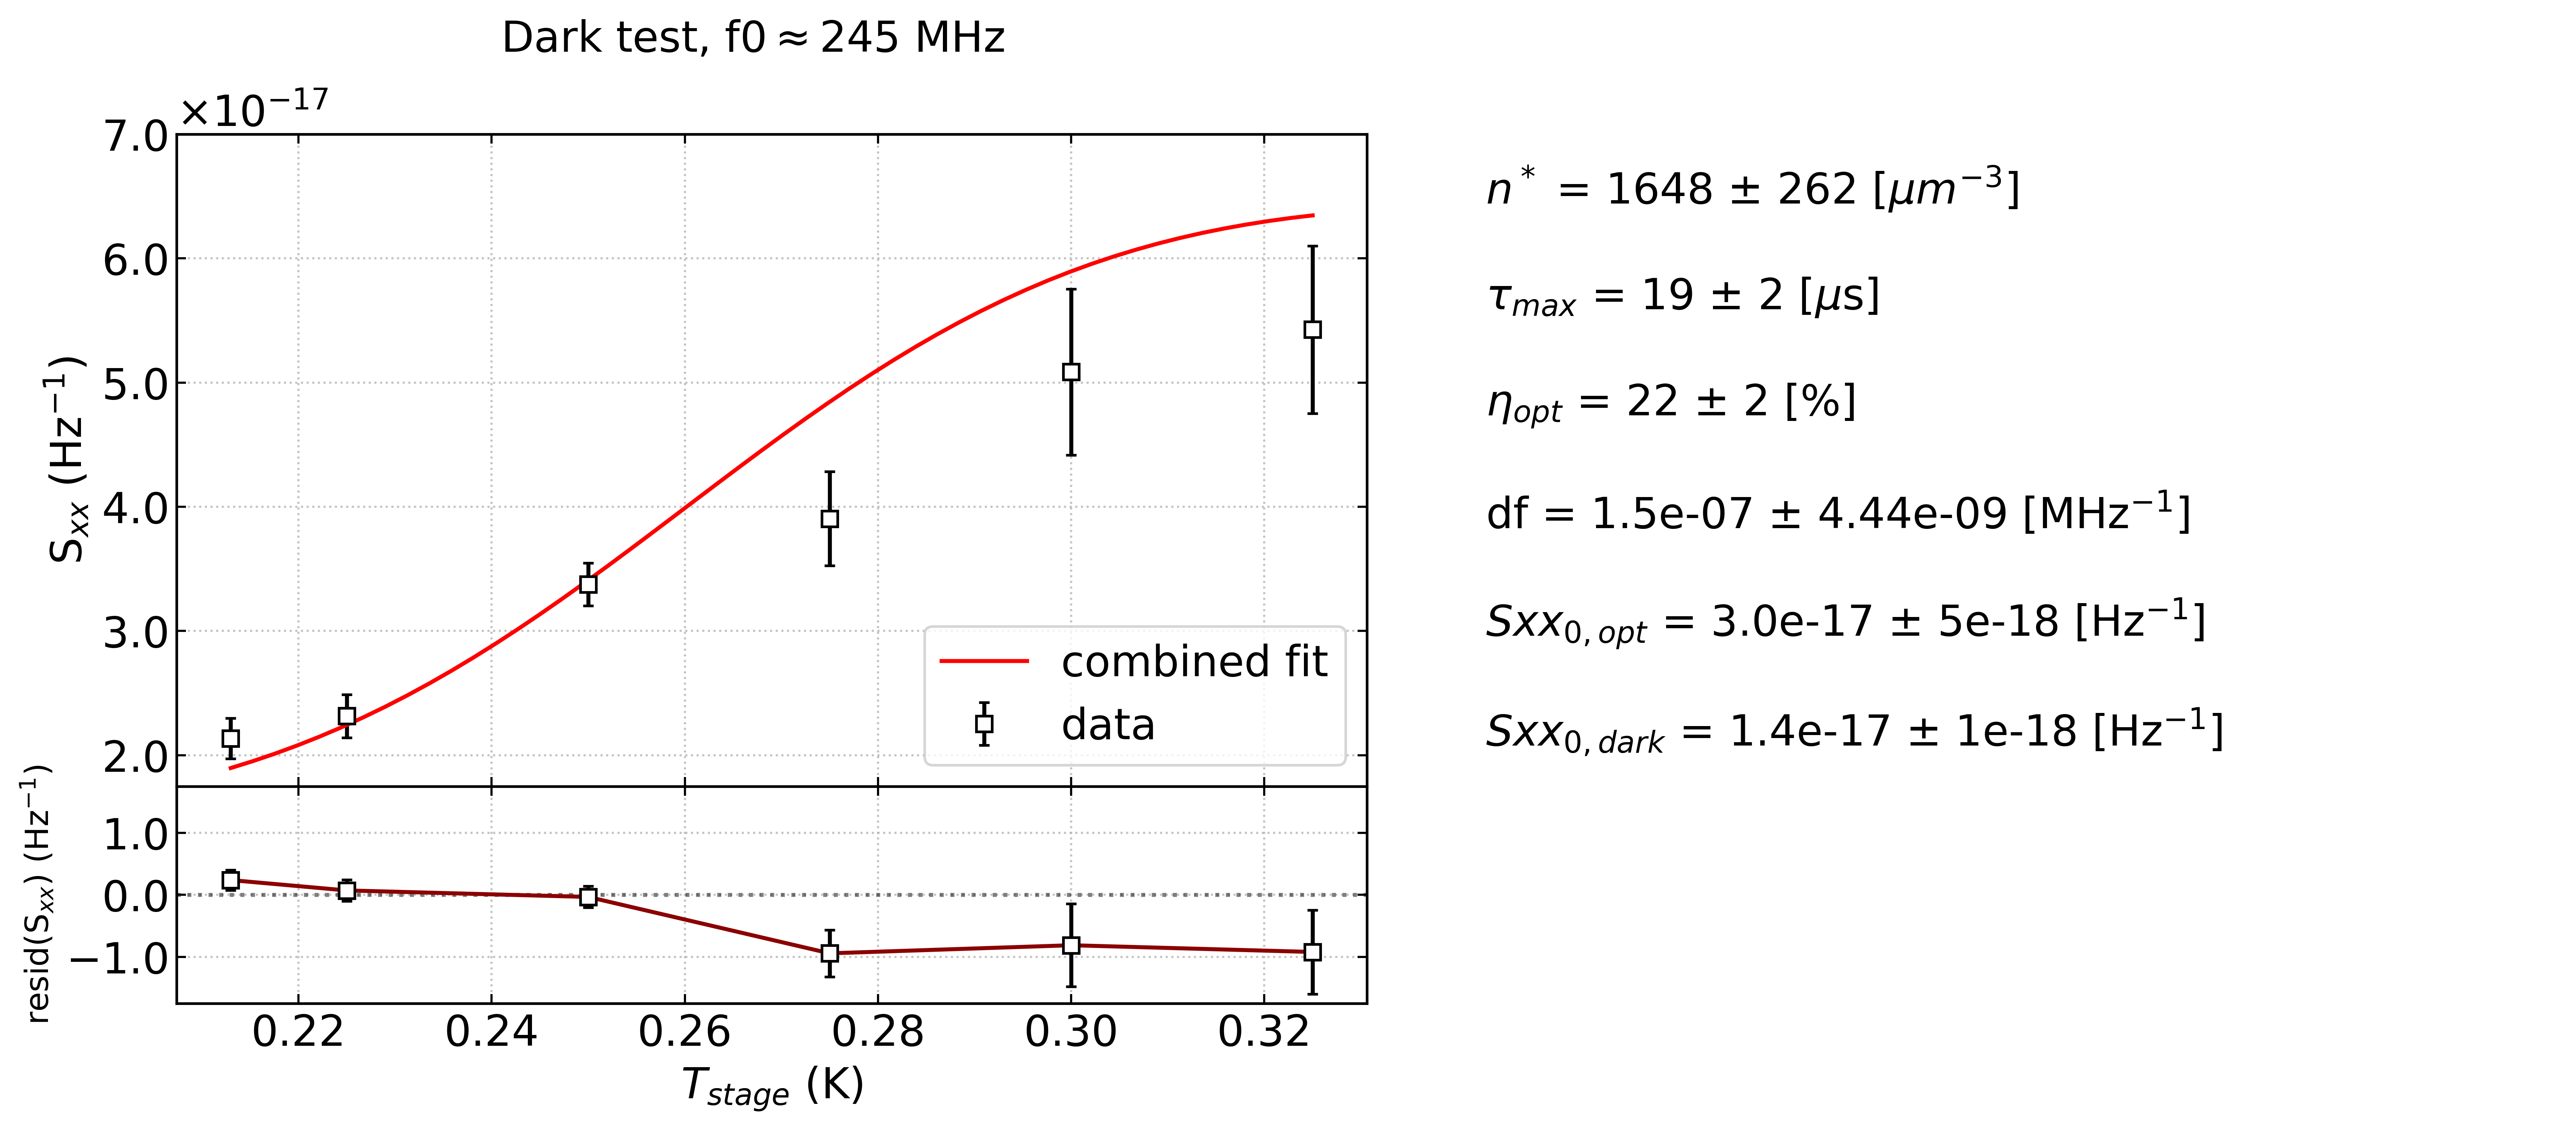

In [13]:
fig2, (p2,p2b) = plt.subplots(2,1,gridspec_kw={'height_ratios':[3, 1]}, sharex=True, figsize=(8,6),dpi=512,facecolor=None)
plt.rc('font', size=16)

fig2.suptitle(r'Sputtered device Dark test, f0$\approx$245 MHz'+'\n',fontsize=16)

p2.errorbar(x=Tstagedarkpts,y=sxxdarkpts,yerr=sxxdarkerr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
p2.plot(Tstagefit,sxxdarkfit,'r-',label='combined fit')
p2.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
p2.tick_params(axis='both',labelsize=16)
fig2.suptitle(r'Dark test, f0$\approx$245 MHz'+'\n',fontsize=16)
p2.legend(loc='lower right',fontsize=16)
p2.set_ylabel(r'S$_{xx}$ (Hz$^{-1}$)',fontsize=16)
p2.set_ylim([1.75e-17,7e-17])

the_table = p2.table(cellText=cell_text, loc='right',cellLoc='left',bbox=[1.0, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)    
for key, cell in the_table.get_celld().items():
    cell.set_linewidth(0)

p2b.errorbar(x=Tstagedarkpts,y=sxxdarkresid,yerr=sxxdarkerr,linestyle='-',color='darkred',fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
p2b.axhline(y=0,color='k',linestyle=':',alpha=0.5)
p2b.set_xlabel(r'$T_{stage}$ (K)',fontsize=16)
p2b.set_ylabel(r'resid(S$_{xx}$) (Hz$^{-1}$)',fontsize=12)
p2b.set_ylim([-1.75e-17,1.75e-17])
p2b.yaxis.offsetText.set_visible(False)
fig2.subplots_adjust(hspace=0)
plt.setp(p2.get_yticklabels()[0], visible=False)

for axe in [p2,p2b]:
    axe.yaxis.set_major_formatter(OOMFormatter(-17, "%1.1f"))
    axe.ticklabel_format(axis='y', style='sci', scilimits=(-17,-17))

if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\dark_Sxx_vs_Tstage_'+plotlabel+'.png')

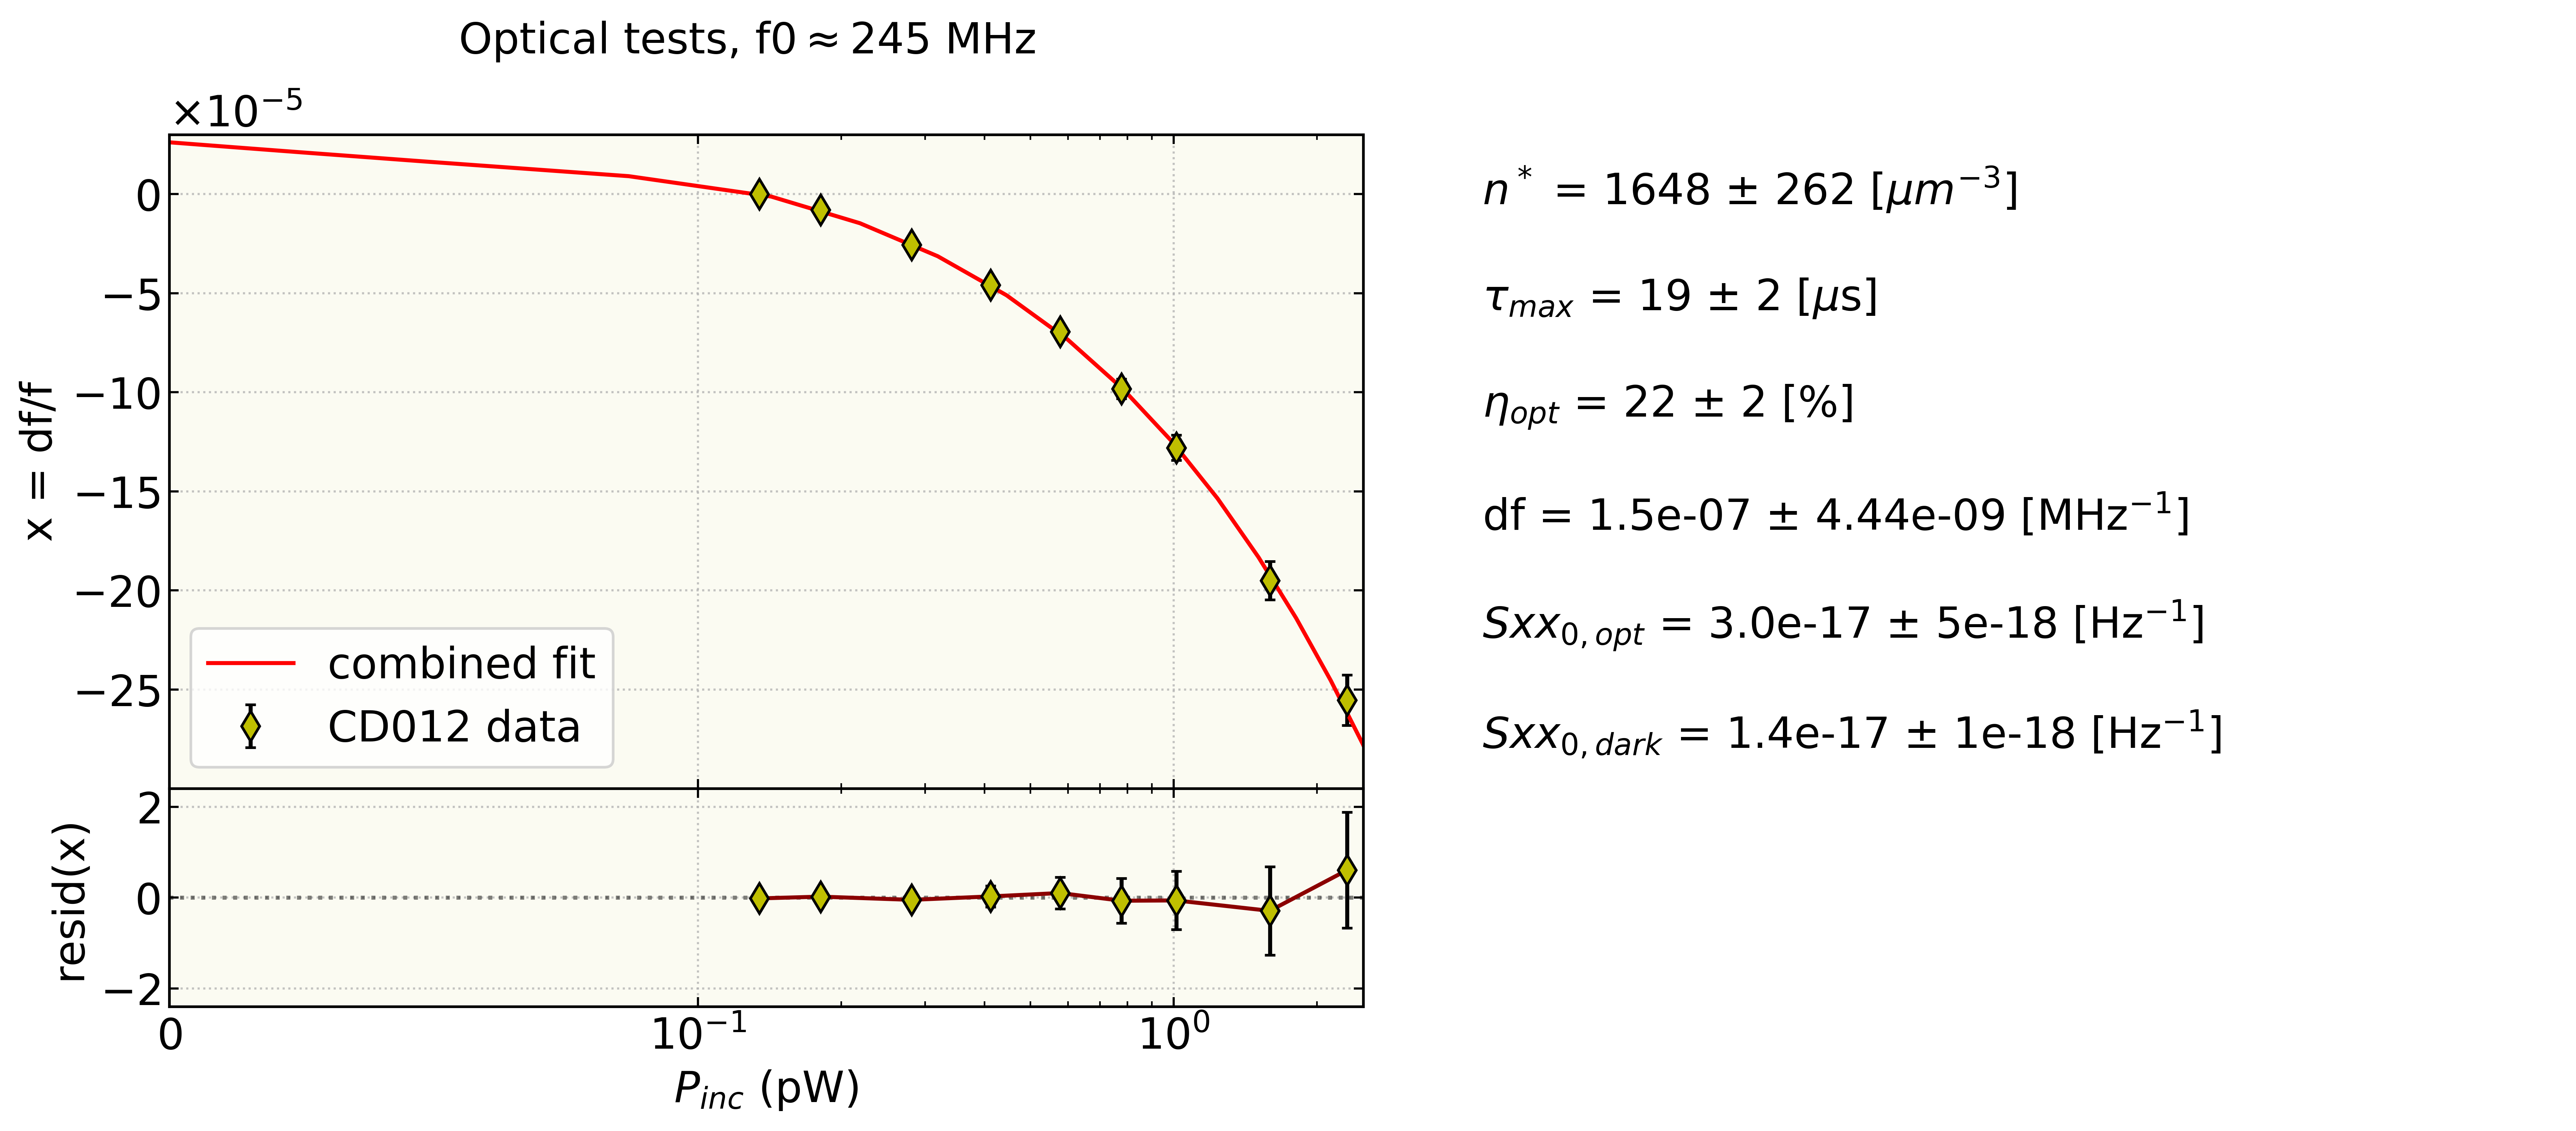

In [14]:
fig2, (p2,p2b) = plt.subplots(2,1,gridspec_kw={'height_ratios':[3, 1]}, sharex=True, figsize=(8,6),dpi=512,facecolor=None)
plt.rc('font', size=16)
p2.errorbar(x=Pincfulloptpts.value,y=xfulloptpts,yerr=xfullopterr,linestyle=None,fmt='d',markersize=8,markerfacecolor='y',markeredgecolor='k',ecolor='k',label='CD012 data')
p2.plot(kids.TBB_to_Pinc(TBBfulloptfit,1),(xfulloptfit),'r-',label='combined fit')

p2.axvspan(0, 2.5, alpha=0.05, color='y')

p2.set_xscale('symlog',linthreshx=1e-1,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
p2.set_xlim([0,2.5])
p2.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.yscale('symlog',linthreshy=1e-7)
p2.set_ylabel('x = df/f',fontsize=16)
p2.set_ylim([-3e-4,3e-5])
p2.tick_params(axis='both',labelsize=16)
fig2.suptitle(r'Optical tests, f0$\approx$245 MHz' + '\n',fontsize=16)
p2.legend(loc='lower left',fontsize=16)

the_table = p2.table(cellText=cell_text, loc='right',cellLoc='left',bbox=[1.0, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)    
for key, cell in the_table.get_celld().items():
    cell.set_linewidth(0)

p2b.errorbar(x=Pincfulloptpts.value,y=xfulloptresid,yerr=xfullopterr,linestyle='-',color='darkred',fmt='d',markerfacecolor='y',markersize=8,markeredgecolor='k',ecolor='k',label='data')
p2b.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
p2b.axhline(y=0,color='k',linestyle=':',alpha=0.5)
p2b.set_ylabel(r'resid(x)',fontsize=16)
p2b.set_ylim([-2.4e-5,2.4e-5])
p2b.axvspan(0, 2.5, alpha=0.05, color='y')

p2b.set_xlabel(r'$P_{inc}$ (pW)',fontsize=16)
fig2.subplots_adjust(hspace=0)
plt.setp(p2.get_yticklabels()[0], visible=False)

for axe in [p2,p2b]:
    axe.yaxis.set_major_formatter(OOMFormatter(-5,"%1.0f"))
    axe.ticklabel_format(axis='y', style='sci', scilimits=(-5,-5))

p2b.yaxis.offsetText.set_visible(False)

if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\opt_x_vs_Pinc_'+plotlabel+'.png')

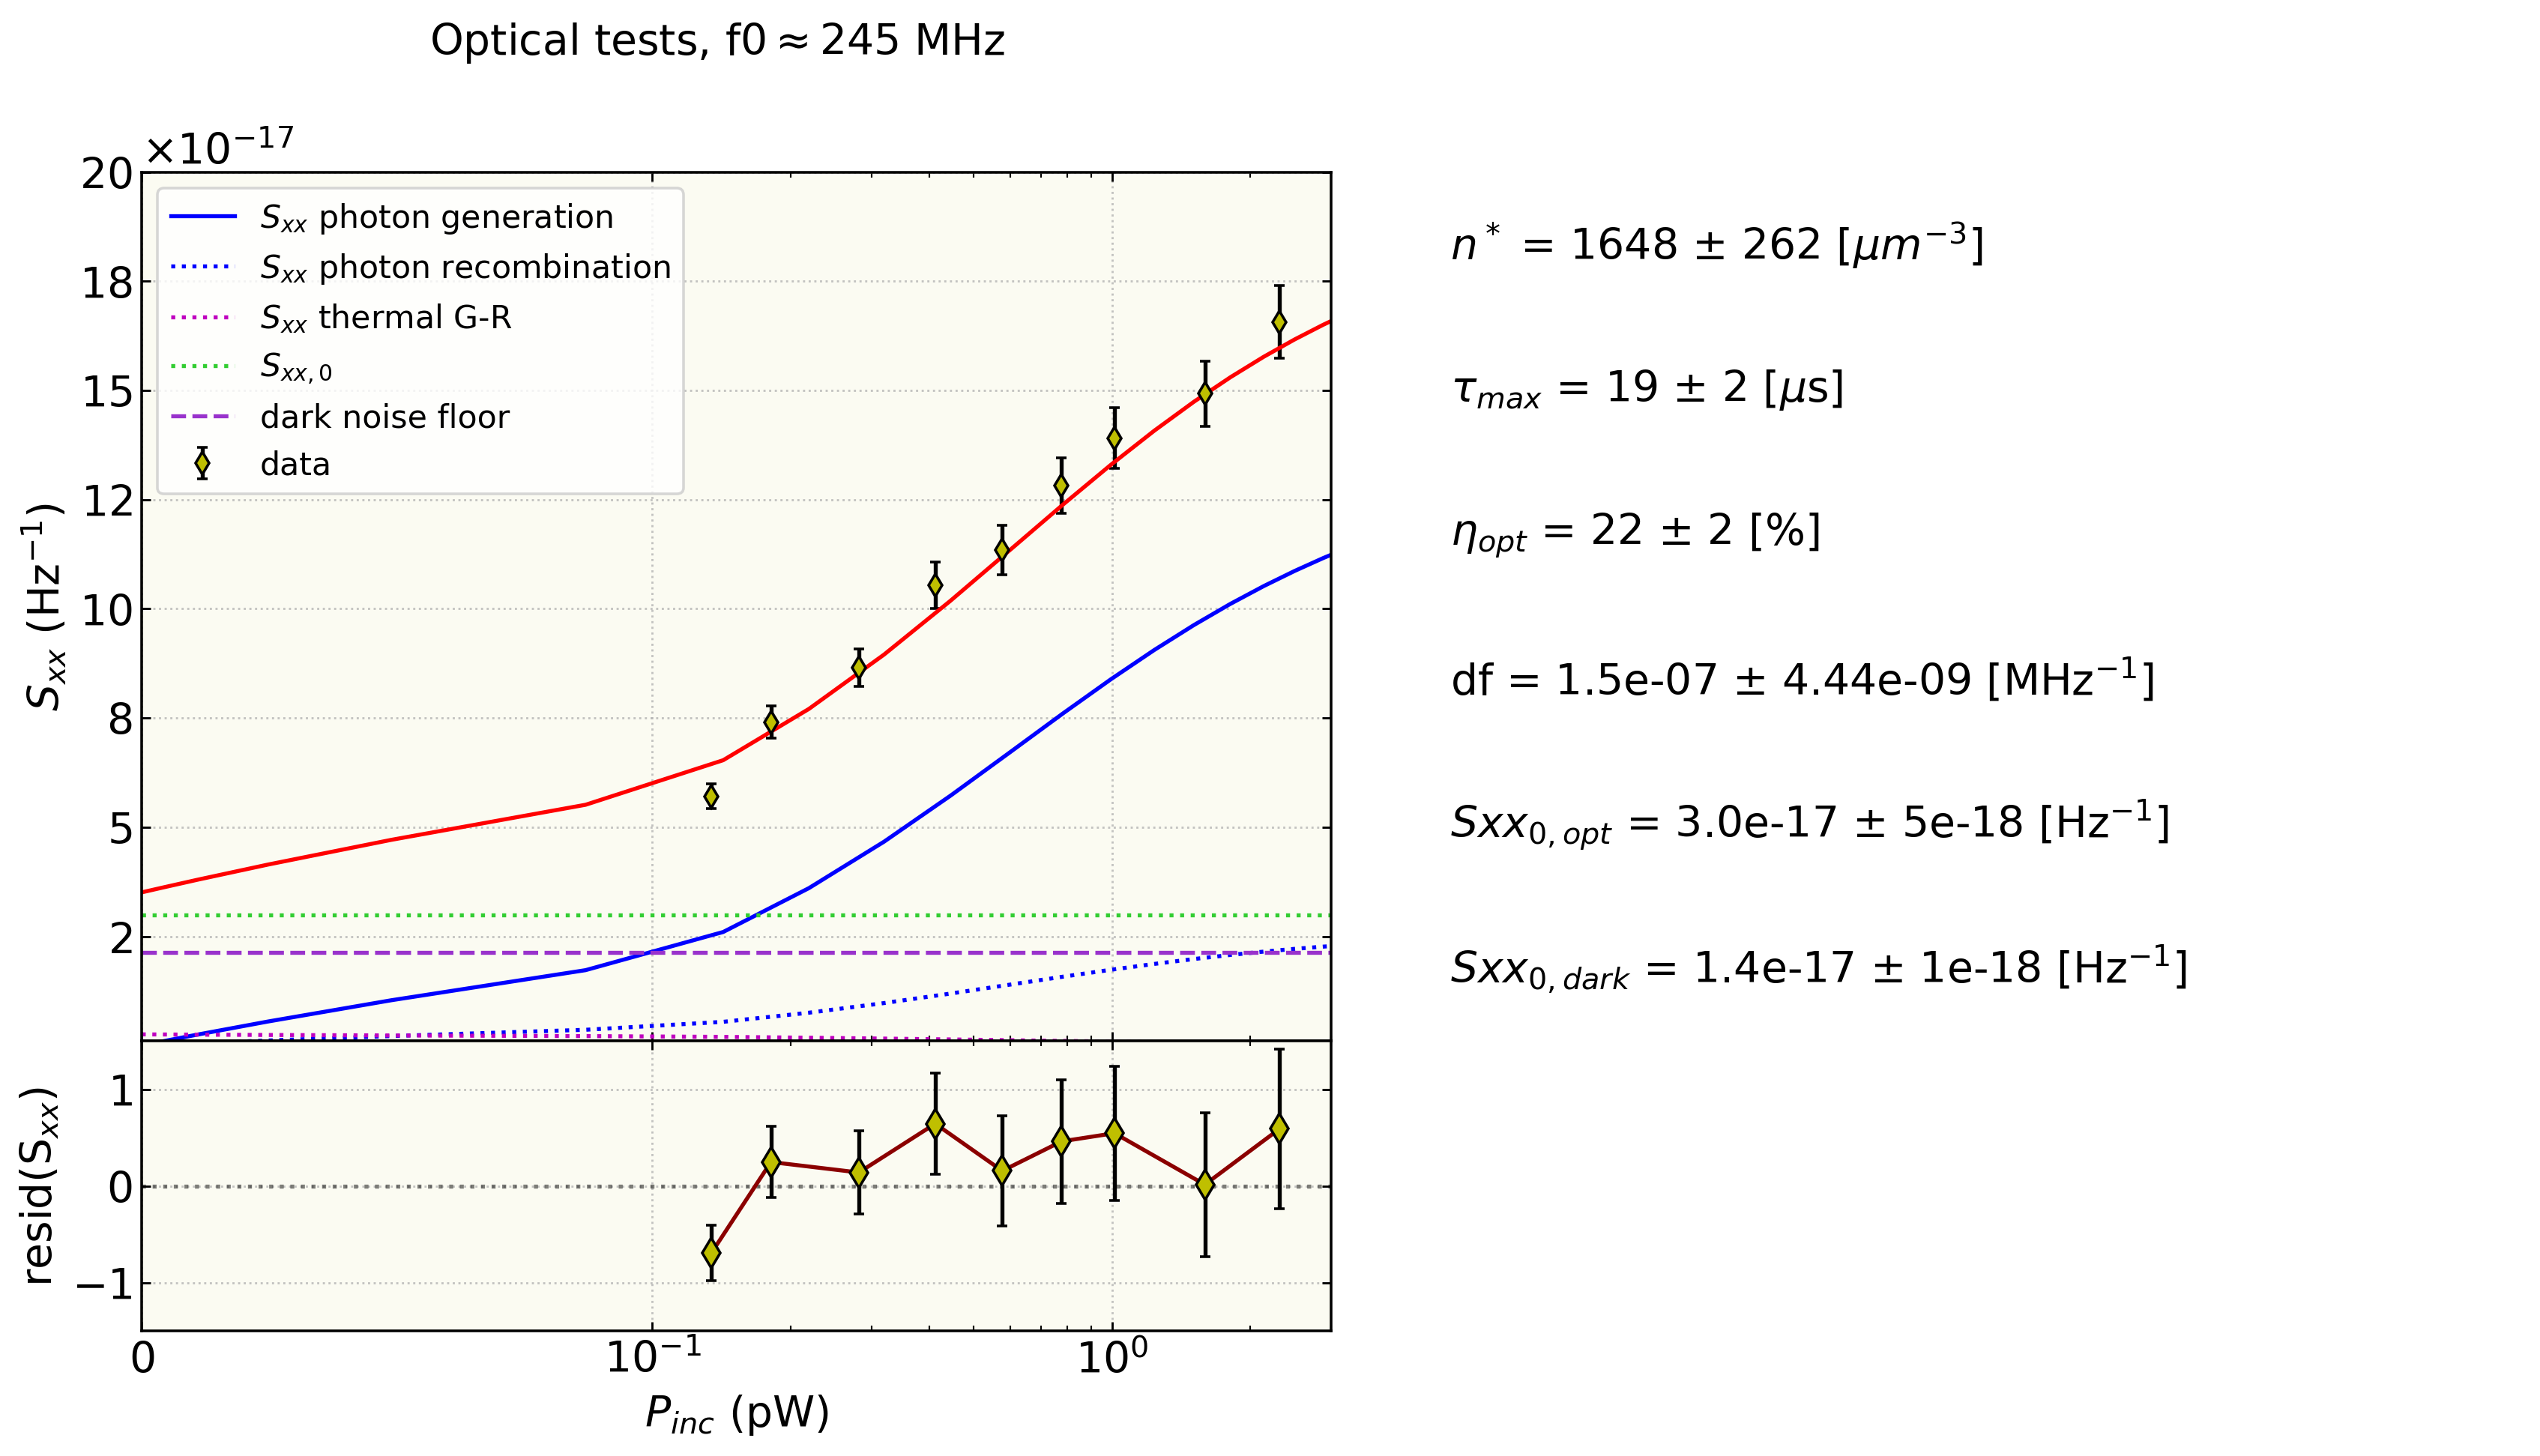

In [19]:
fig2, (p2,p2b) = plt.subplots(2,1,gridspec_kw={'height_ratios':[3, 1]}, sharex=True, figsize=(8,8),dpi=256,facecolor=None)

p2.errorbar(x=Pincfulloptpts.value,y=sxxfulloptpts,yerr=sxxfullopterr,linestyle=None,fmt='d',markerfacecolor='y',markeredgecolor='k',ecolor='k',label='data')
p2.plot(kids.TBB_to_Pinc(TBBfulloptfit,trans=1),sxxfulloptfit,'r-')#,label='combined fit')
p2.plot(kids.TBB_to_Pinc(TBBfulloptfit,trans=1),SxxGfullphoton,linestyle='-',linewidth=1.5,color='b',label=r'$S_{xx}$ photon generation')
p2.plot(kids.TBB_to_Pinc(TBBfulloptfit,trans=1),SxxRfullphoton,linestyle=':',linewidth=1.5,color='b',label=r'$S_{xx}$ photon recombination')
p2.plot(kids.TBB_to_Pinc(TBBfulloptfit,trans=1),SxxGRthfull,linestyle=':',linewidth=1.5,color='m',label=r'$S_{xx}$ thermal G-R')

p2.axvspan(0, 5, alpha=0.05, color='y')
p2.axhline(y=Sxx0opt_fit,linestyle=':',color='limegreen',label=r'$S_{xx,0}$')

#plt.errorbar(x=0,y=sxxdarkpts[0],yerr=sxxdarkerr[0],fmt='o',markersize=5,markerfacecolor='k',markeredgecolor='k',ecolor='k',label='dark noise')
p2.axhline(y=sxxdarkpts[0],color='darkorchid',linestyle='--',label='dark noise floor')

p2.ticklabel_format(axis='y',style='sci',scilimits=(-17,-17))

p2.set_xscale('symlog',linthreshx=1e-1,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
p2.set_xlim([0,3])
#plt.xlim([0.5e-3,1])
#plt.grid(axis='x',which='major')
p2.set_ylabel(r'$S_{xx}$ (Hz$^{-1}$)',fontsize=16)
p2.set_ylim([.1e-17,20e-17])
p2.tick_params(axis='both',labelsize=16)
fig2.suptitle(r'Optical tests, f0$\approx$245 MHz'+'\n',fontsize=16)
p2.legend(loc='upper left',fontsize=12)#,bbox_to_anchor=(1.03, 1.03))

the_table = p2.table(cellText=cell_text, loc='right',cellLoc='left',bbox=[1.0, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)    
for key, cell in the_table.get_celld().items():
    cell.set_linewidth(0)
    
p2b.errorbar(x=Pincfulloptpts.value,y=sxxfulloptresid,yerr=sxxfullopterr,linestyle='-',color='darkred',fmt='d',markersize=8,markerfacecolor='y',markeredgecolor='k',ecolor='k',label='data')

p2b.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
p2b.axhline(y=0,color='k',linestyle=':',alpha=0.5)
#p2b.set_ylabel(r'resid(x)',fontsize=16)
#p2b.set_ylim([-1.75e-7,1.75e-7])
p2b.axvspan(0, 3, alpha=0.05, color='y')

p2b.set_xlabel(r'$P_{inc}$ (pW)',fontsize=16)
p2b.set_ylabel(r'resid(S$_{xx}$)',fontsize=16)
p2b.set_ylim([-1.5e-17,1.5e-17])
fig2.subplots_adjust(hspace=0)
plt.setp(p2.get_yticklabels()[0], visible=False)

for axe in [p2,p2b]:
    axe.yaxis.set_major_formatter(OOMFormatter(-17,"%1.0f"))
    axe.ticklabel_format(axis='y', style='sci', scilimits=(-17,-17))

p2b.yaxis.offsetText.set_visible(False)


if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\opt_sxx_vs_Pinc_'+plotlabel+'.png')

In [18]:
# Estimate NEP = sqrt(Sxx)/(dx/dPabs); Pabs = eta_opt*Pinc

# with T_mask = 1, T_BB = 5.75 K gives P_abs = 0.025 pW
T_BB_NEP = 5.75*u.K
print('Pabs = '+str(eta_opt_fit*kids.TBB_to_Pinc(5.75*u.K,trans=1)))
sxx_NEP = np.power(u.Hz,-1)*sxxfulloptfunc(T_BB_NEP,n_star_fit,tau_max_fit,eta_opt_fit,Sxx0opt_fit)
print('Sxx(Pabs) = ' + str(sxx_NEP))
R_calc = kids.dxdPabs(alpha,f,Tstage,Tc,T_BB_NEP,V,n_star_fit*np.power(u.micron,-3),tau_max_fit*u.microsecond,eta_pb,eta_opt_fit,1)
print('R = ' + str(R_calc))
NEP_meas = np.sqrt(sxx_NEP)/R_calc
print('NEP_meas = ' + str(NEP_meas))
NEP_dev = np.sqrt(sxx_NEP-Sxx0opt_fit*sxx_NEP.unit-kids.Sxx_GR_th(alpha,f,Tstage,Tc,T_BB_NEP,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,1,N0))/R_calc
print('NEP_dev = ' + str(NEP_dev))

Pabs = 0.018201280311109333 pW
Sxx(Pabs) = 5.449959837582428e-17 1 / Hz
R = 195373462.73086098 1 / W
NEP_meas = 3.778601364513234e-17 W / Hz(1/2)
NEP_dev = 2.4208305807710826e-17 W / Hz(1/2)


In [ ]:
n_star_fit

In [ ]:
n_star_fit
tau_max_fit

In [ ]:
n_star_fit

In [ ]:
tau_max_fit

In [ ]:
Tc 

In [20]:
R1 = np.power(n_star_fit*tau_max_fit,-1)

In [21]:
R1

3.23247714490007e-05

In [22]:
tau_0 = 438e-9*u.second

In [24]:
R2 = (np.power(2*kids.delta0(Tc),2)/(2*N0*tau_0*np.power(c.k_B*Tc,3))).to(R1)

UnitConversionError: 'eV micron3 / (J s)' and '' (dimensionless) are not convertible

In [ ]:
R2

In [ ]:
R1/R2

In [ ]:
1./(R2*tau_max_fit)

In [ ]:
# what do good detectors look like???
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.1*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

tau_max = 60*u.microsecond
eta_opt = 0.6
n_star = 100*np.power(u.micron,-3)#1./(R2*tau_max_fit)

TBB = TBBfit
trans = 0.03

In [ ]:
Sxx_m1 = kids.Sxx(alpha,f,Tstage,Tc,TBB,V,n_star,tau_max,eta_pb,nu_opt,eta_opt,trans,N0)

In [ ]:
plt.errorbar(x=kids.TBB_to_Pinc(TBBoptpts,trans).value,y=sxxoptpts,yerr=sxxopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(kids.TBB_to_Pinc(TBB,trans),Sxx_m1,'g:')

In [ ]:
TBBoptpts